# NLP Classifier - TF-IDF Vectorizer

In [1]:
# Import the necessary libraries

import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

%reload_ext autotime

#For visualization
import seaborn as sns
import matplotlib.pyplot as plt  
sns.set(color_codes=True)        #adds color background (have to kill the kernel to see the changes of color)
%matplotlib inline 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import re             #regular expressions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

time: 1.34 s (started: 2021-07-25 15:55:45 +05:30)


## Import and Analyze data

In [2]:
input1 = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\NLP\\Assignment\\blogtext.csv')
input1.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


time: 5.17 s (started: 2021-07-25 15:55:46 +05:30)


In [3]:
print('Shape of blog text data file is: {}'.format(input1.shape))

Shape of blog text data file is: (681284, 7)
time: 0 ns (started: 2021-07-25 15:55:51 +05:30)


We can see that there are 681,284 rows in the dataset. First we will perform operations on smaller dataset by randomizing and then reduce/increase the volume of data based on the kernel capacity.

In [4]:
input1 = shuffle(input1)
# input2 = input1.iloc[0:100000] ## reduce or increase as per system config
input2 = input1

#Reset index after shuffle
input2 = input2.reset_index()
input2 = input2.drop(['index'],axis=1)

time: 250 ms (started: 2021-07-25 15:55:51 +05:30)


In [5]:
input2.dtypes

id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

time: 0 ns (started: 2021-07-25 15:55:52 +05:30)


We can observe that all the features are of object datatype except for id and age. Lets remove features which has less significance like 'id' and 'date'.

In [6]:
input2.drop(['id','date'], axis=1, inplace=True)

time: 62 ms (started: 2021-07-25 15:55:52 +05:30)


In [7]:
# Check null values
input2.isna().any()

gender    False
age       False
topic     False
sign      False
text      False
dtype: bool

time: 125 ms (started: 2021-07-25 15:55:52 +05:30)


There are no null values in any of the columns.

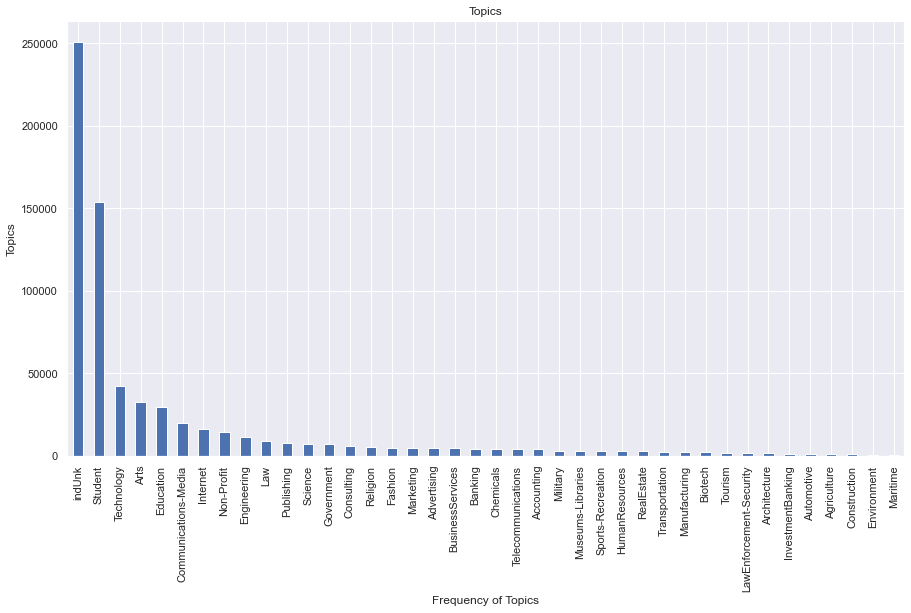

time: 375 ms (started: 2021-07-25 15:55:52 +05:30)


In [8]:
ax = input2['topic'].value_counts().plot(kind='bar',
                                    figsize=(15,8),
                                    title="Topics")
ax.set_xlabel("Frequency of Topics")
ax.set_ylabel("Topics")
plt.show()

As observed in the above plot, topics related to indUnk, student have majority of rows compared to other topics. Maritime and Environment have very less rows.

In [9]:
# Lets typecast 'age' column data to obj type.
input2['age'] = input2['age'].astype(object)

time: 0 ns (started: 2021-07-25 15:55:52 +05:30)


## Data pre-processing

### Data cleansing

1) Let us remove unwanted chars from text column.

In [10]:
alphanum = "[^\w ]"
input2['data_cl'] = input2['text'].apply(lambda x : re.sub(alphanum,"",x))

# input2['data_cl'] = input2['text'].str.replace('[^A-Za-z]',' ')

time: 13.5 s (started: 2021-07-25 15:55:52 +05:30)


2) Removing unwanted spaces

In [11]:
input2['data_cl'] = input2['data_cl'].apply(lambda x: x.strip())

time: 656 ms (started: 2021-07-25 15:56:06 +05:30)


3) Remove stopwords

In [12]:
stopwords=set(stopwords.words('english'))
input2['data_cl'] = input2['data_cl'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

time: 18.1 s (started: 2021-07-25 15:56:07 +05:30)


4) Convert text to lowercase

In [13]:
input2['data_cl'] = input2['data_cl'].apply(lambda x: x.lower())

time: 688 ms (started: 2021-07-25 15:56:25 +05:30)


Lets compare actual text and cleansed text:

In [14]:
print("Actual text  : {}".format(input2['text'][1]))
print('')
print("Cleansed text: {}".format(input2['data_cl'][1]))

Actual text  :        Sooooooo...  I got Dawn and all her hawtness to run on my Radeon 9500.  Whoo yeah.   Thanks, Alex, for leaving that half full can of Cherry Pepsi.  You left some stuff.  Here.  Just FYI.         

Cleansed text: sooooooo i got dawn hawtness run radeon 9500 whoo yeah thanks alex leaving half full cherry pepsi you left stuff here just fyi
time: 31 ms (started: 2021-07-25 15:56:25 +05:30)


### Target/label merger and transformation

As this will a a multi-label classification problem, we need to merge all the label columns together so that we have all the labels together for a particular sentence.

In [15]:
input2['labels']=input2.apply(lambda col: [col['gender'],str(col['age']),col['topic'],col['sign']], axis=1)

time: 21.8 s (started: 2021-07-25 15:56:25 +05:30)


In [16]:
input2.head()

,gender,age,topic,sign,text,data_cl,labels
0,female,27,BusinessServices,Pisces,In this room you inhaled the essen...,in room inhaled essence one hundred years i sa...,"[female, 27, BusinessServices, Pisces]"
1,male,16,Student,Gemini,Sooooooo... I got Dawn and all her haw...,sooooooo i got dawn hawtness run radeon 9500 w...,"[male, 16, Student, Gemini]"
2,male,17,Student,Virgo,"May 16th, 2004 history was made at the ...",may 16th 2004 history made vevoda compound we ...,"[male, 17, Student, Virgo]"
3,male,25,Tourism,Gemini,According to the MLB's official site th...,according mlbs official site top 10 reasons be...,"[male, 25, Tourism, Gemini]"
4,male,14,Maritime,Pisces,*A reminder. The Sarcastic Kitten sys...,a reminder the sarcastic kitten system film re...,"[male, 14, Maritime, Pisces]"


time: 16 ms (started: 2021-07-25 15:56:47 +05:30)


In [17]:
# We will drop text,gender,age,topic & sign as they are already merged
input2.drop(columns=['text','gender','age','topic','sign'], axis=1, inplace=True)

time: 203 ms (started: 2021-07-25 15:56:47 +05:30)


In [18]:
input2.head()

,data_cl,labels
0,in room inhaled essence one hundred years i sa...,"[female, 27, BusinessServices, Pisces]"
1,sooooooo i got dawn hawtness run radeon 9500 w...,"[male, 16, Student, Gemini]"
2,may 16th 2004 history made vevoda compound we ...,"[male, 17, Student, Virgo]"
3,according mlbs official site top 10 reasons be...,"[male, 25, Tourism, Gemini]"
4,a reminder the sarcastic kitten system film re...,"[male, 14, Maritime, Pisces]"


time: 0 ns (started: 2021-07-25 15:56:47 +05:30)


The function below will visualize the words and their frequency in a set of documents. Let’s use it to find out the most frequent words in the cleansed text column:

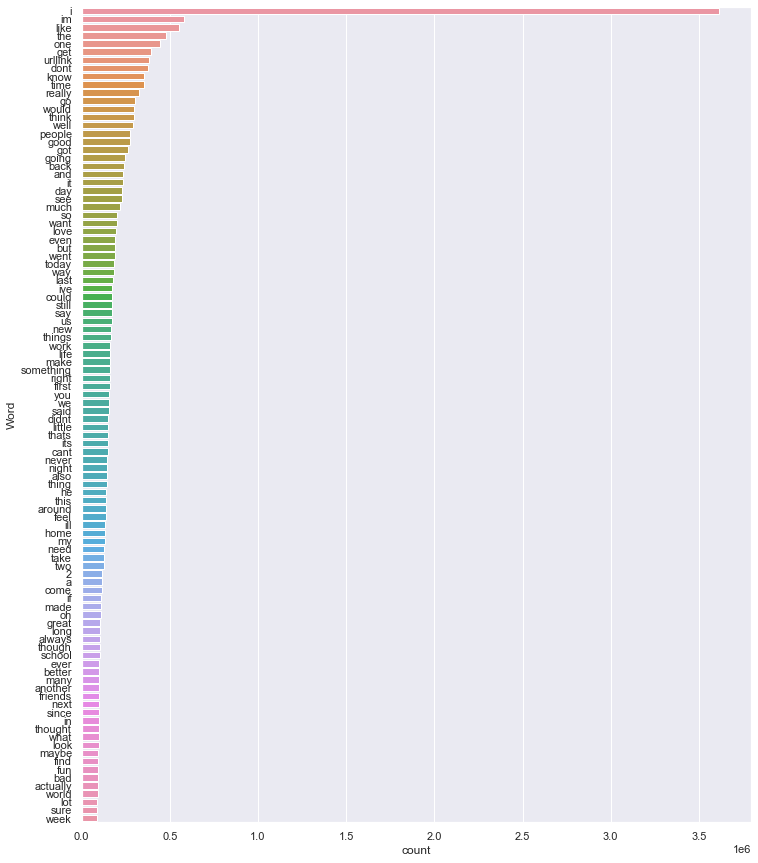

time: 1min 24s (started: 2021-07-25 15:56:48 +05:30)


In [19]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(input2['data_cl'], 100)

In [20]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return ' '.join(no_stopword_text)

input2['data_cl'] = input2['data_cl'].apply(lambda x: remove_stopwords(x))

time: 14.8 s (started: 2021-07-25 15:58:12 +05:30)


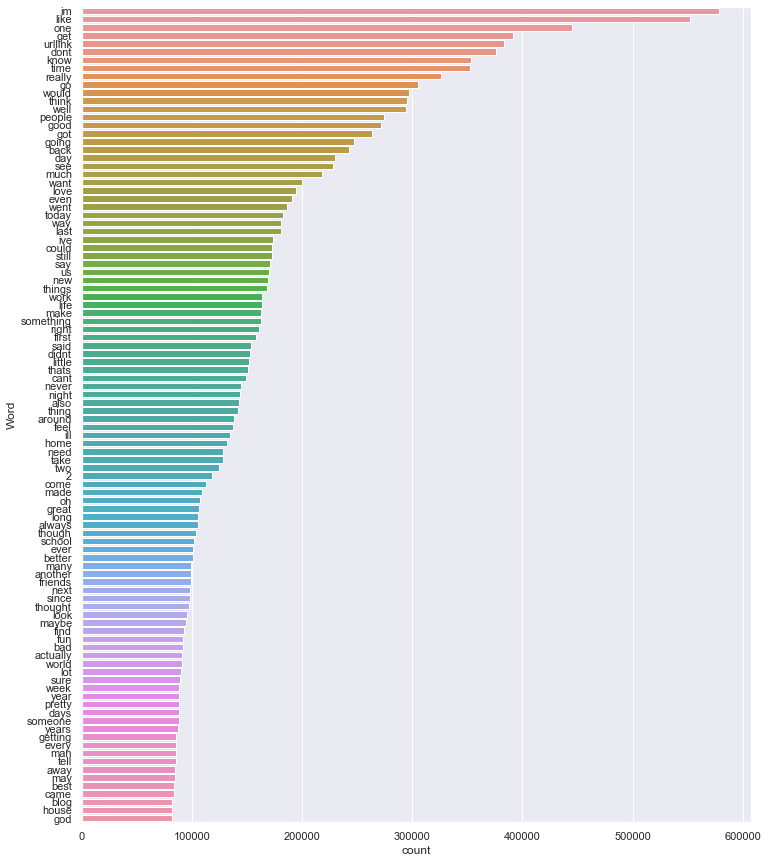

time: 55.6 s (started: 2021-07-25 15:58:27 +05:30)


In [21]:
freq_words(input2['data_cl'], 100)

We will create a dictionary to get the count of every label i.e. the key will be label name and value will be the total count of the label.

In [22]:
label_counts=dict()

for labels in input2.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label]+=1
        else:
            label_counts[label]=1

time: 1.05 s (started: 2021-07-25 15:59:23 +05:30)


In [23]:
label_counts

{'female': 336091,
 '27': 46124,
 'BusinessServices': 4500,
 'Pisces': 54053,
 'male': 345193,
 '16': 72708,
 'Student': 153903,
 'Gemini': 51985,
 '17': 80859,
 'Virgo': 60399,
 '25': 67051,
 'Tourism': 1942,
 '14': 27400,
 'Maritime': 280,
 'Aquarius': 49687,
 'indUnk': 251015,
 '24': 80071,
 'Capricorn': 49201,
 'Libra': 62363,
 '23': 72889,
 '38': 7545,
 'Leo': 53811,
 'Cancer': 65048,
 '45': 4482,
 'Technology': 42055,
 'Taurus': 62561,
 'Communications-Media': 20140,
 'RealEstate': 2870,
 'Aries': 64979,
 'Sagittarius': 50036,
 '43': 4230,
 'Education': 29633,
 '15': 41767,
 'Scorpio': 57161,
 '37': 9317,
 '26': 55312,
 'Law': 9040,
 '13': 13133,
 'Internet': 16006,
 'Banking': 4049,
 'Accounting': 3832,
 '48': 3572,
 '40': 5016,
 'Biotech': 2234,
 'Non-Profit': 14700,
 '34': 21347,
 '39': 5556,
 'Engineering': 11653,
 'Agriculture': 1235,
 '35': 17462,
 'Religion': 5235,
 'HumanResources': 3010,
 'Government': 6907,
 '41': 3738,
 '42': 2908,
 'Arts': 32449,
 'Automotive': 1244,


time: 16 ms (started: 2021-07-25 15:59:24 +05:30)


In [24]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(input2['labels'])

# transform target variable
y = multilabel_binarizer.transform(input2['labels'])

time: 985 ms (started: 2021-07-25 15:59:24 +05:30)


### Train and test split and Vectorization

A vectorizer helps us convert text data to computer understandable numeric data.

CountVectorizer: Counts the frequency of all words in our corpus, sorts them and grabs the most recurring features (using max_features hyperparameter). But these results are mostly biased and our model might loose out on some of the important less frequent features. These are all boolean values.

TFIDFVectorizer: TFIDF is a statistical measure said to have fixed the issues with CountVectorizer in some way. It consists of 2 parts, TF (Term Frequency) multiplied with IDF (Inverse Document Frequency). The main intuition being some words that appear frequently in 1 document and less frequently in other documents could be considered as providing extra insight for that 1 document and could help our model learn from this additional piece of information. In short, common words are penalized. These are relative frequencies identified as floating point numbers.

In [25]:
tfidf_vectorizer = TfidfVectorizer() #max_df=0.8, max_features=10000)

time: 0 ns (started: 2021-07-25 15:59:25 +05:30)


In [26]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(input2['data_cl'], y, test_size=0.3, random_state=7)

time: 2.47 s (started: 2021-07-25 15:59:25 +05:30)


In [27]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

time: 53.6 s (started: 2021-07-25 15:59:27 +05:30)


## Train, tune and test the best text classifier

Here we will use the One-vs-Rest approach, which is implemented in OneVsRestClassifier class. In this approach k classifiers (= number of tags) are trained. As a basic classifier, we can use LogisticRegression . It is one of the simplest methods, but often it performs good enough in text classification tasks.

Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).

In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.

The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [28]:
# Let's check hyperparameters for few classification models

# lrcl =  LogisticRegression()
# nbcl =  MultinomialNB()
# dtcl = DecisionTreeClassifier()
# knncl =  KNeighborsClassifier()

svcl = LinearSVC(penalty = 'l2', multi_class = 'ovr', class_weight = 'balanced', C=0.1)                       

# rfcl =  RandomForestClassifier()
# bgcl =  BaggingClassifier()

# One vs Rest Classifier

# ovr_lrcl = OneVsRestClassifier(lrcl)
# ovr_nbcl = OneVsRestClassifier(nbcl)
# ovr_dtcl = OneVsRestClassifier(dtcl)
# ovr_knncl = OneVsRestClassifier(knncl)

ovr_svcl = OneVsRestClassifier(svcl)

# ovr_rfcl = OneVsRestClassifier(rfcl)
# ovr_bgcl = OneVsRestClassifier(bgcl)

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


***********************************************************************************************
##### Below commented code lines were used to test different algorithms on small data. Linear SVC proved to be efficient compared to other algorithms.
***********************************************************************************************

In [29]:
# Pipeline all the models

# pipe_lr = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs')))])
# pipe_nb = Pipeline([('clf', OneVsRestClassifier(MultinomialNB()))])
# pipe_dt = Pipeline([('clf', OneVsRestClassifier(DecisionTreeClassifier()))])
# pipe_knn = Pipeline([('clf', OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 2, algorithm = 'auto')))])
# pipe_svc = Pipeline([('clf', OneVsRestClassifier(LinearSVC()))])
# pipe_rf = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier()))])
# pipe_bc = Pipeline([('clf', OneVsRestClassifier(BaggingClassifier()))])

# pipe_lr.fit(xtrain_tfidf, ytrain) 
# pipe_nb.fit(xtrain_tfidf, ytrain) 
# pipe_dt.fit(xtrain_tfidf, ytrain) 
# pipe_knn.fit(xtrain_tfidf, ytrain) 
# pipe_svc.fit(xtrain_tfidf, ytrain) 
# pipe_rf.fit(xtrain_tfidf, ytrain) 
# pipe_bc.fit(xtrain_tfidf, ytrain) 

# Training dataset Scores 
# lr_train = pipe_lr.score(xtrain_tfidf, ytrain)
# nb_train = pipe_nb.score(xtrain_tfidf, ytrain)
# dt_train = pipe_dt.score(xtrain_tfidf, ytrain)
# knn_train = pipe_knn.score(xtrain_tfidf, ytrain)
# svc_train = pipe_svc.score(xtrain_tfidf, ytrain)
# rf_train = pipe_rf.score(xtrain_tfidf, ytrain)
# bc_train = pipe_bc.score(xtrain_tfidf, ytrain)

# # Testing dataset Scores
# lr_test = pipe_lr.score(xval_tfidf, yval)
# nb_test = pipe_nb.score(xval_tfidf, yval)
# dt_test = pipe_dt.score(xval_tfidf, yval)
# knn_test = pipe_knn.score(xval_tfidf, yval)
# svc_test = pipe_svc.score(xval_tfidf, yval)
# rf_test = pipe_rf.score(xval_tfidf, yval)
# bc_test = pipe_bc.score(xval_tfidf, yval)

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [30]:
# y_pred_lr = pipe_lr.predict(xval_tfidf)
# y_pred_nb = pipe_nb.predict(xval_tfidf)
# y_pred_dt = pipe_dt.predict(xval_tfidf)
# y_pred_knn = pipe_knn.predict(xval_tfidf)
# y_pred_svc = pipe_svc.predict(xval_tfidf)
# y_pred_rf = pipe_rf.predict(xval_tfidf)
# y_pred_bc = pipe_bc.predict(xval_tfidf)

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [31]:
# print(metrics.classification_report(yval, y_pred_lr))

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [32]:
# print('Model: ', pipe_lr)
# print('Accuracy score: ', accuracy_score(yval, y_pred_lr))
# print('F1 score: ', f1_score(yval, y_pred_lr, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_lr, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_lr, average='micro'))
# print('')

# print('Model: ', pipe_nb)
# print('Accuracy score: ', accuracy_score(yval, y_pred_nb))
# print('F1 score: ', f1_score(yval, y_pred_nb, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_nb, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_nb, average='micro'))
# print('')

# print('Model: ', pipe_dt)
# print('Accuracy score: ', accuracy_score(yval, y_pred_dt))
# print('F1 score: ', f1_score(yval, y_pred_dt, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_dt, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_dt, average='micro'))
# print('')

# print('Model: ', pipe_knn)
# print('Accuracy score: ', accuracy_score(yval, y_pred_knn))
# print('F1 score: ', f1_score(yval, y_pred_knn, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_knn, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_knn, average='micro'))
# print('')

# print('Model: ', pipe_svc)
# print('Accuracy score: ', accuracy_score(yval, y_pred_svc))
# print('F1 score: ', f1_score(yval, y_pred_svc, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_svc, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_svc, average='micro'))
# print('')

# print('Model: ', pipe_rf)
# print('Accuracy score: ', accuracy_score(yval, y_pred_rf))
# print('F1 score: ', f1_score(yval, y_pred_rf, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_rf, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_rf, average='micro'))
# print('')

# print('Model: ', pipe_bc)
# print('Accuracy score: ', accuracy_score(yval, y_pred_bc))
# print('F1 score: ', f1_score(yval, y_pred_bc, average='micro'))
# print('Average precision score: ', average_precision_score(yval, y_pred_bc, average='micro'))
# print('Average recall score: ', recall_score(yval, y_pred_bc, average='micro'))
# print('')

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [33]:
# f1_micro_lr = f1_score(yval, y_pred_lr, average='micro')
# f1_macro_lr = f1_score(yval, y_pred_lr, average='macro')
# f1_weighted_lr = f1_score(yval, y_pred_lr, average='weighted')
# f1_sample_lr = f1_score(yval, y_pred_lr, average='samples')

# f1_micro_nb = f1_score(yval, y_pred_nb, average='micro')
# f1_macro_nb = f1_score(yval, y_pred_nb, average='macro')
# f1_weighted_nb = f1_score(yval, y_pred_nb, average='weighted')
# f1_sample_nb = f1_score(yval, y_pred_nb, average='samples')

# f1_micro_dt = f1_score(yval, y_pred_dt, average='micro')
# f1_macro_dt = f1_score(yval, y_pred_dt, average='macro')
# f1_weighted_dt = f1_score(yval, y_pred_dt, average='weighted')
# f1_sample_dt = f1_score(yval, y_pred_dt, average='samples')

# f1_micro_knn = f1_score(yval, y_pred_knn, average='micro')
# f1_macro_knn = f1_score(yval, y_pred_knn, average='macro')
# f1_weighted_knn = f1_score(yval, y_pred_knn, average='weighted')
# f1_sample_knn = f1_score(yval, y_pred_knn, average='samples')

# f1_micro_svc = f1_score(yval, y_pred_svc, average='micro')
# f1_macro_svc = f1_score(yval, y_pred_svc, average='macro')
# f1_weighted_svc = f1_score(yval, y_pred_svc, average='weighted')
# f1_sample_svc = f1_score(yval, y_pred_svc, average='samples')

# f1_micro_rf = f1_score(yval, y_pred_rf, average='micro')
# f1_macro_rf = f1_score(yval, y_pred_rf, average='macro')
# f1_weighted_rf = f1_score(yval, y_pred_rf, average='weighted')
# f1_sample_rf = f1_score(yval, y_pred_rf, average='samples')

# f1_micro_bc = f1_score(yval, y_pred_bc, average='micro')
# f1_macro_bc = f1_score(yval, y_pred_bc, average='macro')
# f1_weighted_bc = f1_score(yval, y_pred_bc, average='weighted')
# f1_sample_bc = f1_score(yval, y_pred_bc, average='samples')

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [34]:
# data = {'F1 score (micro)': [f1_micro_lr, f1_micro_nb, f1_micro_dt, f1_micro_knn, f1_micro_svc, f1_micro_rf, f1_micro_bc],
#         'F1 score (macro)': [f1_macro_lr, f1_macro_nb, f1_macro_dt, f1_macro_knn, f1_macro_svc, f1_macro_rf, f1_macro_bc],
#         'F1 score (weighted)': [f1_weighted_lr, f1_weighted_nb, f1_weighted_dt, f1_weighted_knn, f1_weighted_svc, f1_weighted_rf, f1_weighted_bc],
#         'F1 score (samples)': [f1_sample_lr, f1_sample_nb, f1_sample_dt, f1_sample_knn, f1_sample_svc, f1_sample_rf, f1_sample_bc],
#        } 

# pd.DataFrame(data,
#              index = ['Logistic Regression', 'Naive Bayes', 'Decision Tree','KNN',
#                       'Linear SVC', 'Random Forest', 'Bagging Classifier' ])

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [35]:
# for clf, label in zip([lrcl, nbcl, dtcl, knncl, svcl, rfcl, bgcl], 
#     ['Logistic Regression', 'Naive Bayes Classifier', 'Decision Tree Classifier', 'K-Nearest Neighbor Classifier', 
#      'Linear SVC', 'Random Forest Classifier', 'Bagging Classfier']):
#     print("Model name: ", label)
#     print("Hyperparameters:", clf.get_params() )
#     print('')

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [36]:
# params={
#     'penalty': ('l1', 'l2'),
#     'loss': ('squared_hinge'),
#     'C': (0.01, 0.1, 1, 10),
#     'multi_class': ('ovr')
#     'estimator__fit_intercept': (True),
#     'estimator__class_weight': ('dict', 'balanced')
# }
# random_tune=RandomizedSearchCV(svcl, param_distributions=params, scoring='f1_micro', verbose=10)

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [37]:
# fit model on train data
# clf.fit(xtrain_tfidf, ytrain)
# random_tune.fit(xtrain_tfidf,ytrain)

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


In [38]:
# print("Best parameters set found on development set:")
# print('')
# print(random_tune.best_params_)

time: 0 ns (started: 2021-07-25 16:00:21 +05:30)


*********************************************************************************************************************
##### Commented code lines end here
*********************************************************************************************************************

In [39]:
# Fit the model
pipe_svc = Pipeline([('clf', ovr_svcl)])
pipe_svc.fit(xtrain_tfidf, ytrain) 

Pipeline(steps=[('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=0.1,
                                                         class_weight='balanced')))])

time: 45min 40s (started: 2021-07-25 16:00:21 +05:30)


In [40]:
# make predictions for validation set
y_pred = pipe_svc.predict(xval_tfidf)

time: 5.36 s (started: 2021-07-25 16:46:01 +05:30)


In [41]:
y_pred[3]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0])

time: 0 ns (started: 2021-07-25 16:46:07 +05:30)


In [42]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('23',
 '24',
 'Aquarius',
 'Arts',
 'Capricorn',
 'Pisces',
 'Student',
 'female',
 'indUnk')

time: 656 ms (started: 2021-07-25 16:46:07 +05:30)


## Classification report

In [43]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.350480098574941

time: 1.48 s (started: 2021-07-25 16:46:07 +05:30)


In [44]:
def print_evaluation_scores(y_test, y_pred):
    print('Accuracy score: ', accuracy_score(yval, y_pred))
    print('F1 score: ', f1_score(yval, y_pred, average='micro'))
    print('Average precision score: ', average_precision_score(yval, y_pred, average='micro'))
    print('Average recall score: ', recall_score(yval, y_pred, average='micro'))

time: 0 ns (started: 2021-07-25 16:46:09 +05:30)


In [45]:
print_evaluation_scores(yval, y_pred)

Accuracy score:  0.018313387414010743
F1 score:  0.350480098574941
Average precision score:  0.16538787324811985
Average recall score:  0.5662349671699627
time: 5.34 s (started: 2021-07-25 16:46:09 +05:30)


The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem.

Precision can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives.

Recall is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. 

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

Experimenting with lots of featurization and including topic modelling improved my score. Random search helped in hyperparameter tuning and a decent micro f1 score of 0.4302 was achieved on test data.

## True vs Predicted labels

In [46]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

time: 0 ns (started: 2021-07-25 16:46:14 +05:30)


In [47]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = pipe_svc.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

time: 0 ns (started: 2021-07-25 16:46:14 +05:30)


In [48]:
for i in range(25): 
  k = xval.sample(1).index[0] 
  print("Actual labels   : ", input2['labels'][k])
  print("Predicted labels: ", infer_tags(xval[k]))
  print('')

Actual labels   :  ['male', '35', 'Technology', 'Aries']
Predicted labels:  [('23', '24', '25', 'Architecture', 'Aries', 'Arts', 'Communications-Media', 'Leo', 'female', 'indUnk')]

Actual labels   :  ['female', '23', 'indUnk', 'Aries']
Predicted labels:  [('23', '25', 'Aries', 'Capricorn', 'Libra', 'female', 'indUnk')]

Actual labels   :  ['male', '24', 'indUnk', 'Gemini']
Predicted labels:  [('16', '26', '27', '37', 'Aquarius', 'Sagittarius', 'female', 'indUnk')]

Actual labels   :  ['male', '34', 'indUnk', 'Aries']
Predicted labels:  [('25', '33', '34', 'Aries', 'Gemini', 'Internet', 'Scorpio', 'Technology', 'indUnk', 'male')]

Actual labels   :  ['female', '34', 'indUnk', 'Cancer']
Predicted labels:  [('16', '41', 'Aquarius', 'Architecture', 'Cancer', 'Chemicals', 'Leo', 'Libra', 'indUnk', 'male')]

Actual labels   :  ['female', '24', 'Education', 'Capricorn']
Predicted labels:  [('33', 'Aquarius', 'Gemini', 'Student', 'Transportation', 'Virgo', 'female', 'indUnk')]

Actual labels 

Most of the predictions are pretty close to the actual labels.